In [16]:
import pandas as pd
import math
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [17]:
path = 'demand_inventory.csv'
df = pd.read_csv(path)

In [18]:
df.head()

,Unnamed: 0,Date,Product_ID,Demand,Inventory
0,0,2023-06-01,P1,51,5500
1,1,2023-06-02,P1,141,5449
2,2,2023-06-03,P1,172,5308
3,3,2023-06-04,P1,91,5136
4,4,2023-06-05,P1,198,5045


In [19]:
df['DemandDiff'] = df['Demand'].diff().dropna()

In [20]:
df = df.drop('Unnamed: 0', axis=1)

In [21]:
df['Date'] = pd.to_datetime(df['Date'])

In [22]:
df = df.set_index('Date')

In [23]:
df.head()

,Product_ID,Demand,Inventory,DemandDiff
Date,,,,
2023-06-01,P1,51,5500,NaN
2023-06-02,P1,141,5449,90.0
2023-06-03,P1,172,5308,31.0
2023-06-04,P1,91,5136,-81.0
2023-06-05,P1,198,5045,107.0


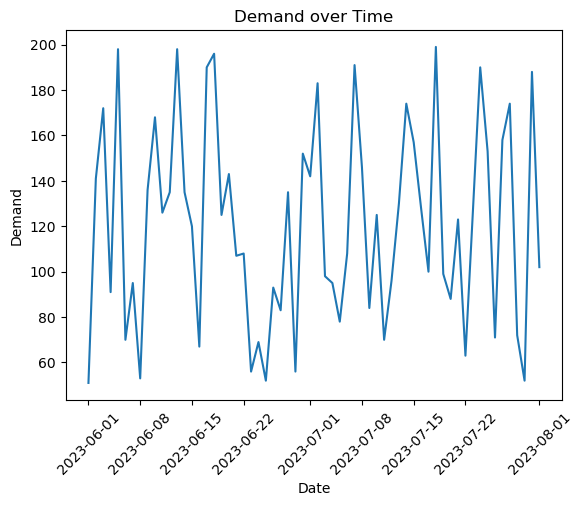

In [24]:
sns.lineplot(data=df, x=df.index, y=df['Demand'])
plt.title('Demand over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.show()

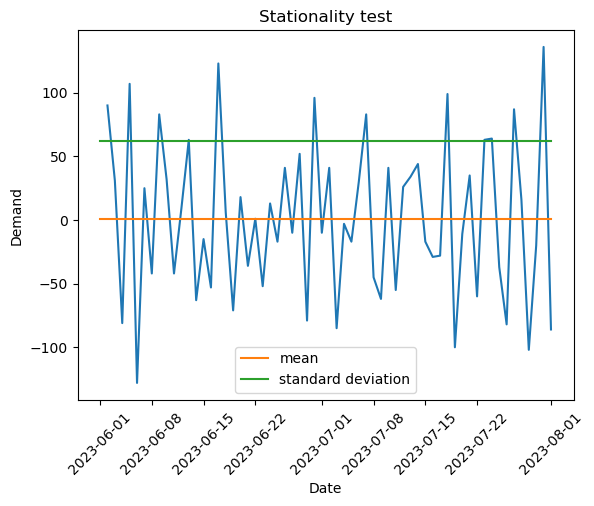

In [25]:
sns.lineplot(data=df, x=df.index, y=df['DemandDiff'])
sns.lineplot(data=df, x=df.index, y=df['DemandDiff'].mean(), label='mean')
sns.lineplot(data=df, x=df.index, y=df['DemandDiff'].std(), label='standard deviation')
plt.title('Stationality test')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.legend()
plt.show()

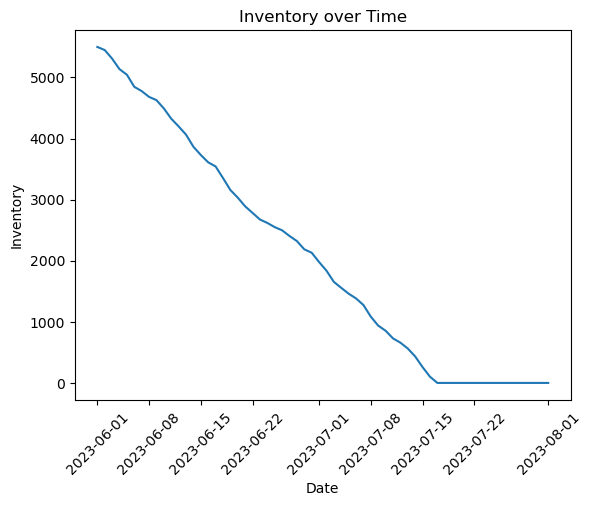

In [26]:
sns.lineplot(data=df, x=df.index, y=df['Inventory'])
plt.title('Inventory over Time')
plt.xlabel('Date')
plt.ylabel('Inventory')
plt.xticks(rotation=45)
plt.show()

C:\Users\Niner\anaconda\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


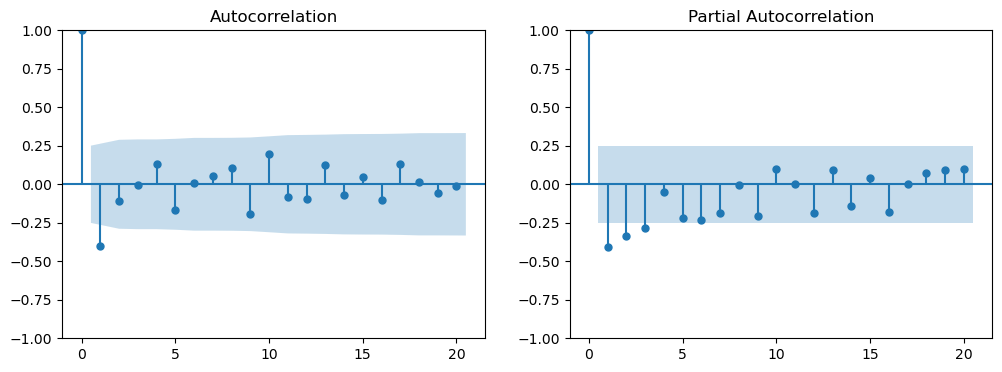

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(df['Demand'].diff().dropna(), lags=20, ax=axes[0]) #q
plot_pacf(df['Demand'].diff().dropna(), lags=20, ax=axes[1]) #p
plt.show()

In [32]:
train = df[:round(len(df)*70/100)]
test = df[round(len(df)*70/100):]

In [108]:
model = SARIMAX(train['Demand'], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit()
predictions = model_fit.predict(test.index[0], test.index[-1])

C:\Users\Niner\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Niner\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Niner\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [109]:
rmse = np.sqrt(mean_squared_error(test['Demand'], predictions))
rmse

64.07070682793781

In [110]:
futureDates = pd.DataFrame(pd.date_range(start='2023-08-02', end='2023-09-01', freq='D'), columns=['Date'])
futureDates.set_index('Date', inplace=True)

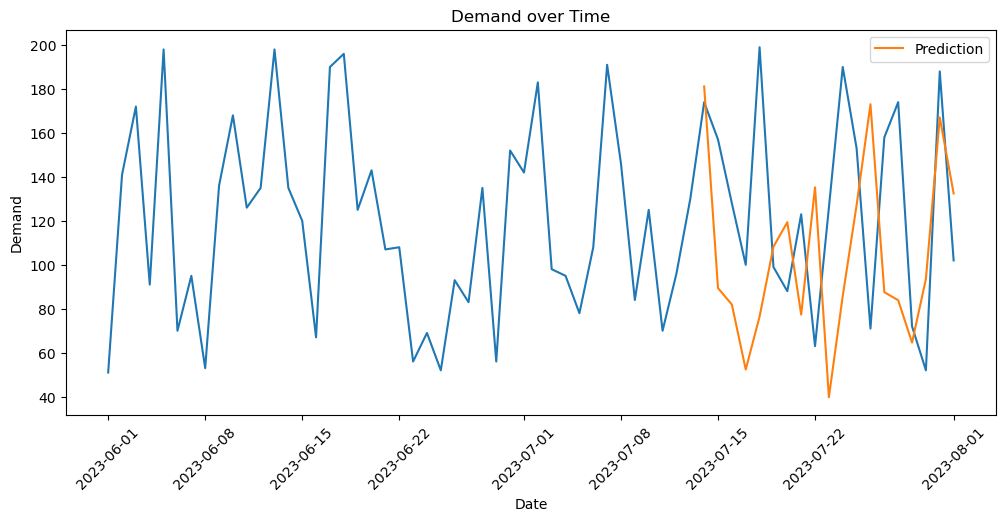

In [111]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x=df.index, y=df['Demand'])
sns.lineplot(data=predictions, x=predictions.index, y=predictions, label='Prediction')
plt.title('Demand over Time')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.show()

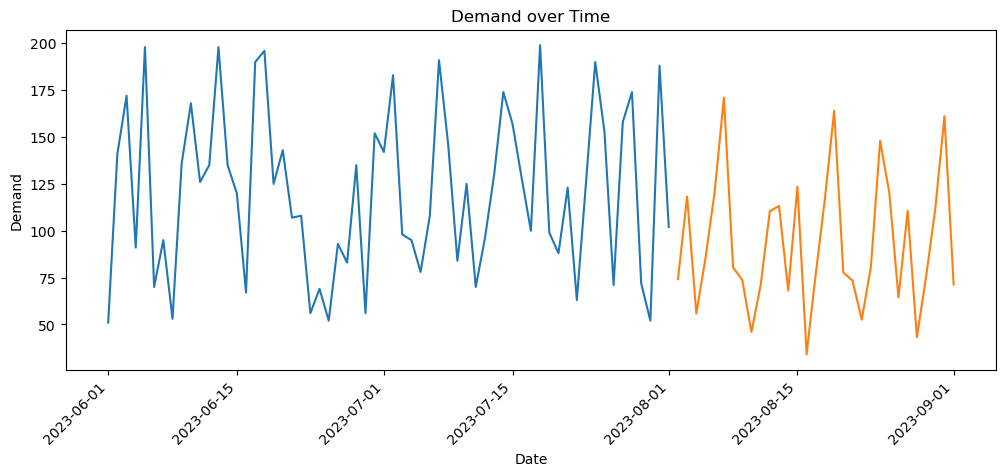

In [112]:
plt.figure(figsize=(12,5))
sns.lineplot(data=df, x=df.index, y=df['Demand'])
model_fit.predict(start=futureDates.index[0], end=futureDates.index[-1]).plot()
plt.title('Demand over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.xticks(rotation=45)
plt.show()

In [113]:
forecasted_demand = model_fit.predict(start=futureDates.index[0], end=futureDates.index[-1])
initial_inventory = 5500
lead_time = 1
service_level = 0.95

In [114]:
# Calculate the optimal order quantity using the Newsvendor formula
z = np.abs(np.percentile(forecasted_demand, 100 * (1 - service_level)))
order_quantity = np.ceil(forecasted_demand.mean() + z).astype(int)
reorder_point = forecasted_demand.mean() * lead_time + z
safety_stock = reorder_point - forecasted_demand.mean() * lead_time

In [115]:
# Calculate the total cost (holding cost + stockout cost)
holding_cost = 0.1 
stockout_cost = 50 
total_holding_cost = holding_cost * (initial_inventory + 0.5 * order_quantity)
total_stockout_cost = stockout_cost * np.maximum(0, forecasted_demand.mean() * lead_time - initial_inventory)

total_cost = total_holding_cost + total_stockout_cost

In [116]:
print("Optimal Order Quantity:", order_quantity)
print("Reorder Point:", round(reorder_point, 2))
print("Safety Stock:", round(safety_stock, 2))
print("Total Cost:", total_cost)

Optimal Order Quantity: 138
Reorder Point: 137.95
Safety Stock: 44.57
Total Cost: 556.9
